# Assignment 3 - Bike Sharing Demand


# Abstract

Aim: To determine the best model for predictions using the RMSLE value.
The competition is to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.Various models are used to derive the best set of predictions.Root Mean Square Logarithmic Error(RMSLE) is the metric used to judge the effectiveness of the models.The model that gives the least RMSLE is considered as the best.Ensemble models results in less RMSLE values then others. Gradient Boost method shows better performance than all the models in this notebook. The derived predictions are validated against the test data to determine the score on the leaderboard.



In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Data Cleaning & Visualizations

In [4]:
df["date"] = df.datetime.apply(lambda x : x.split()[0])
df["hour"] = df.datetime.apply(lambda x : x.split()[1].split(":")[0])
df["weekday"] = df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df["month"] = df.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

In [5]:
df  = df.drop(["datetime"],axis=1)

The "datetime" column is split into date, hour, day and month to reduce the complexity. The datetime column is dropped as it is no more needed.

In [21]:
from sklearn.preprocessing import LabelEncoder
number=LabelEncoder()
df['hour']=number.fit_transform(df['hour'].astype('str'))
df['weekday']=number.fit_transform(df['weekday'].astype('str'))
df['month']=number.fit_transform(df['month'].astype('str'))


In [7]:
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
date          0
hour          0
weekday       0
month         0
dtype: int64

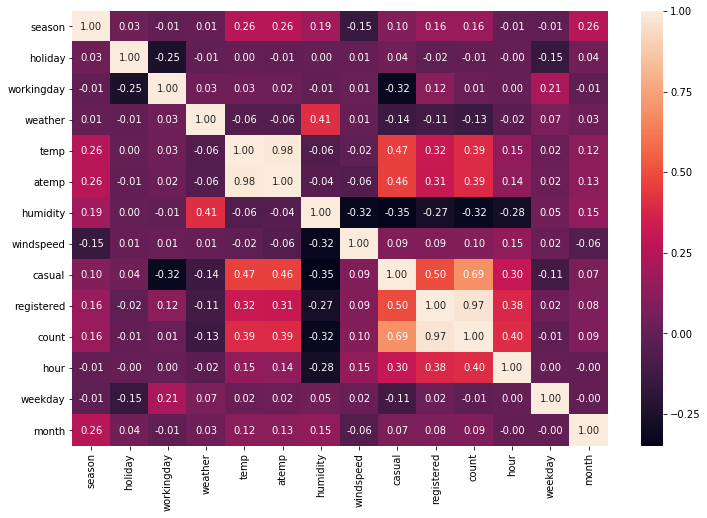

In [8]:
plt.figure(figsize=(12,8))
sn.heatmap(data=df.iloc[:,:].corr(),annot=True,fmt='.2f')
plt.show()

Observations:

1.temp and atemp(feels like) are highly related.This might result in multicollinearity. 

2.humidity is inversely related to count.This shows that as the climate is more humid less people travel on bikes.

3.count and holiday are highly inversely related as less people use bikes on holidays.

4.weather and count are highly inversely related.We can infer that as the temperature gets worse, less people will use the bike.

5.registered and count are highly related which indicates that most of the bikes that are rented are registered.

In [9]:
df  = df.drop(["atemp"],axis=1)

The "atemp" column is removed as it is of no use and it is very much related to the "temp" column

C:\Users\manog\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


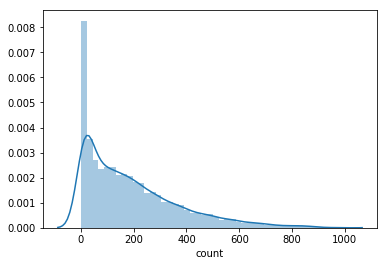

In [10]:
sn.distplot(df['count'])
plt.show()

The above distribution shows that the data is highly skewed in the right. To remove this, we can apply log to the Y_test data in the further steps while calculating the RMSLE value.Thus we can scale down the range of response variable to get a better result.

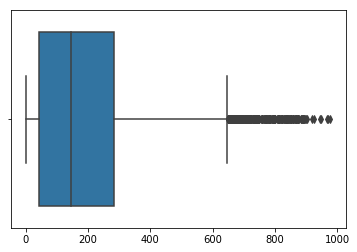

In [11]:
sn.boxplot(np.array(df['count']))

The above boxplot shows that our target variable has many outliers. These are removed in the next step

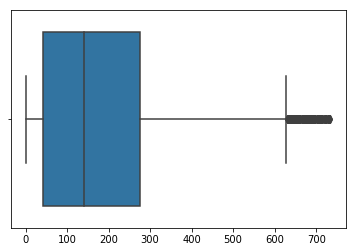

In [12]:
df = df[np.abs(df["count"]-df["count"].mean())<=(3*df["count"].std())]
sn.boxplot(np.array(df['count']))

The target variable is re-checked for outliers using boxplot. We can see that though the outliers are removed, the data is not normally distributed.

In [13]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

function for calculating RMSLE value

# Linear Regression 

In [22]:
X = pd.DataFrame(np.c_[df['season'], df['holiday'], df['workingday'], df['weather'], df['temp'],df['humidity'],df['windspeed'],df['casual'],df['registered'],df['hour'],df['weekday'],df['month']], columns = ['season','holiday','workingday','weather','temp','humidity','windspeed','casual','registered','hour','weekday','month'])

Y = df['count']

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [24]:
lin_model = LinearRegression()
r=lin_model.fit(X_train, np.log1p(Y_train))

In [25]:
predictions=lin_model.predict(X_test)
predictions

array([5.43228933, 3.6153031 , 4.89111969, ..., 5.01865486, 5.03394068,
       4.05928824])

In [26]:
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(np.log1p(Y_test)),np.exp(predictions),False))

RMSLE Value For Linear Regression:  0.7146272273279002


We can see the RMSLE value for a Linear Regression model. This can be further lessned by using techniques like Regularization and Ensemble models

# Ensemble models

Random Forest

In [27]:
rfModel = RandomForestRegressor(n_estimators=100)
rfModel.fit(X_train,np.log1p(Y_train))
preds = rfModel.predict(X=X_test)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(Y_test)),np.exp(preds),False))

RMSLE Value For Random Forest:  0.010841819964351398


Gradient Boost

In [33]:
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); 
gbm.fit(X_train,np.log1p(Y_train))
predsgb = gbm.predict(X=X_test)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(np.log1p(Y_test)),np.exp(predsgb),False))

RMSLE Value For Gradient Boost:  0.005500967730862043


In [29]:
import xgboost as xg
gbm = xg.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train,np.log1p(Y_train))
predictions = gbm.predict(X_test)
print ("RMSLE Value For  XGBoost: ",rmsle(np.exp(np.log1p(Y_test)),np.exp(predictions),False))


RMSLE Value For  XGBoost:  0.07342038777185693


In [36]:
test_df=pd.read_csv('test.csv')
datetimecol=test_df["datetime"]
submission = pd.DataFrame({
        "datetime": datetimecol,
        "count": [max(0, x) for x in np.exp(predsgb)]
    })
submission.to_csv('my_submission.csv', index=False)


# Conclusion

By executing various models, it has been observed that Gradient Boost performs better than the rest. Performance of the models is measured using RMSLE. The RMSLE value is least when Gradient Boost method is used.After submitting the result file to Kaggle, the score is recorded as 0.42289 which is placed at 489th position

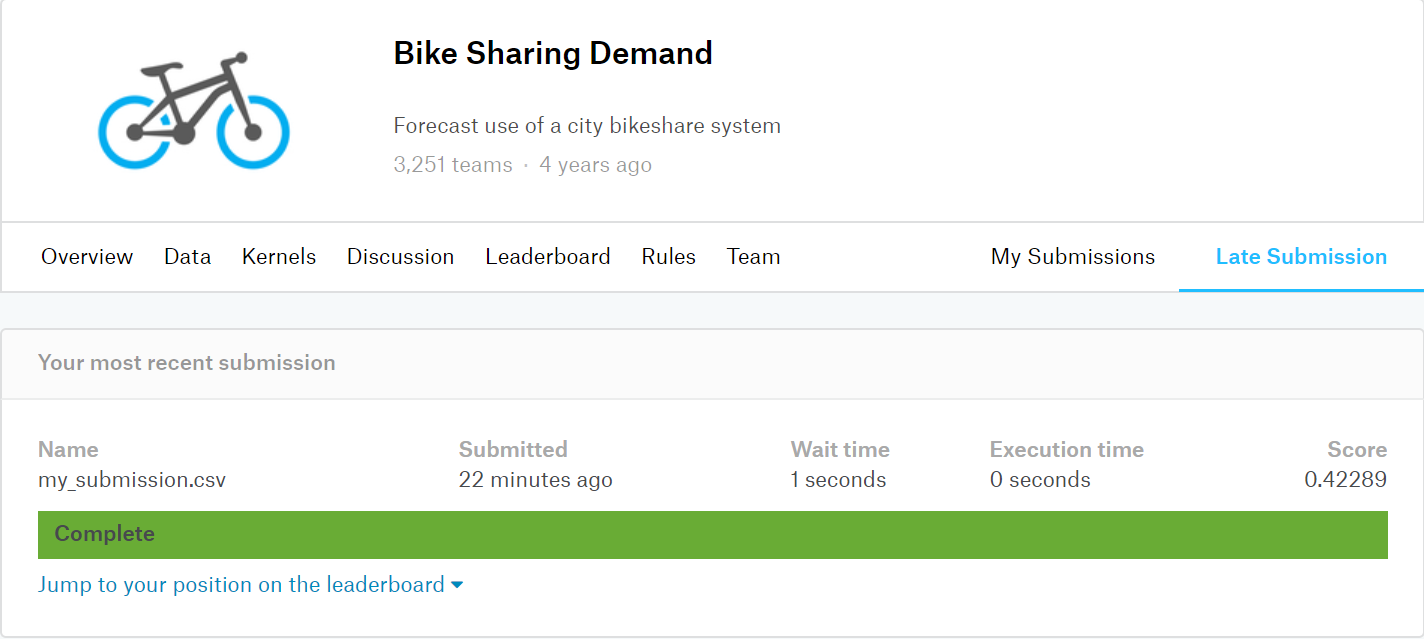

# Contribution

Performed data cleaning and visualizations.Executed various models to analyse their performance.

self : 70%

internet : 30%

# Citations

https://www.kaggle.com/c/bike-sharing-demand

https://medium.com/@viveksrinivasan/how-to-finish-top-10-percentile-in-bike-sharing-demand-competition-in-kaggle-part-2-29e854aaab7d

https://stats.stackexchange.com/questions/58525/re-check-boxplot-after-outlier-removal

https://stackoverflow.com/questions/42785920/runtimewarning-overflow-encountered-in-square?rq=1

https://stats.stackexchange.com/questions/56658/how-do-you-interpret-rmsle-root-mean-squared-logarithmic-error

https://www.kaggle.com/questions-and-answers/47140

Fanaee-T, Hadi, and Gama, Joao, Event labeling combining ensemble detectors and background knowledge, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.


# License

Copyright 2019 Manogjna Potluri
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
